In [1]:
import pandas as pd
import numpy as np
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\NAUFAL
[nltk_data]     HAFIZH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["text","label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
df=pd.read_csv('data/csv/cleaned/LionAir.csv')

In [5]:
print("Dataset size : ",len(df))

Dataset size :  198


In [6]:
df.head()

,text,label
0,Being re-booked on this flight I was not rea...,0
1,"Filthy airplane, delays, and no whatsoever i...",0
2,Makassar to Surabaya. Searching for the chea...,0
3,Makassar to Singapore via Jakarta. Expensive...,0
4,Jakarta to Denpasar. Due to take off 7 pm. D...,0


In [7]:
decode_map={0:'NEGATIVE',1:"POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.label=df.label.apply(lambda x:decode_sentiment(x))

CPU times: total: 0 ns
Wall time: 1 ms


Text(0.5, 1.0, 'Dataset Labels Distribution')

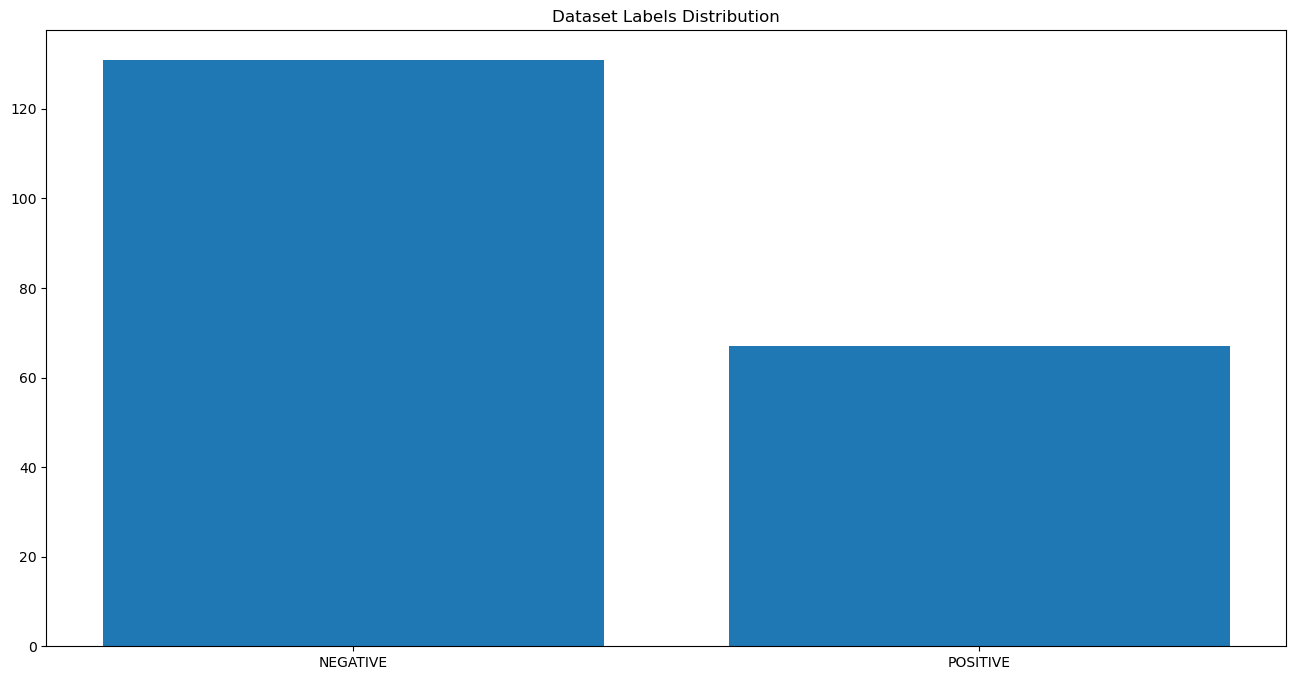

In [9]:
label_cnt=Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(),label_cnt.values())
plt.title("Dataset Labels Distribution")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 62.5 ms
Wall time: 58 ms


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 158
TEST size: 40


In [19]:
%%time
documents = [text.split() for text in df_train.text] 

CPU times: total: 0 ns
Wall time: 2 ms


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,window=W2V_WINDOW,min_count=W2V_MIN_COUNT,workers=8)

2023-03-07 19:37:56,044 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-03-07T19:37:56.044794', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [21]:
w2v_model.build_vocab(documents)

2023-03-07 19:37:57,339 : INFO : collecting all words and their counts
2023-03-07 19:37:57,340 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-03-07 19:37:57,342 : INFO : collected 2163 word types from a corpus of 8713 raw words and 158 sentences
2023-03-07 19:37:57,343 : INFO : Creating a fresh vocabulary
2023-03-07 19:37:57,346 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 179 unique words (8.28% of original 2163, drops 1984)', 'datetime': '2023-03-07T19:37:57.346172', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2023-03-07 19:37:57,347 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 4526 word corpus (51.95% of original 8713, drops 4187)', 'datetime': '2023-03-07T19:37:57.347172', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platfo

In [22]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 179


In [23]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-03-07 19:38:03,868 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 179 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-03-07T19:38:03.868268', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
2023-03-07 19:38:03,948 : INFO : EPOCH 0: training on 8713 raw words (2486 effective words) took 0.0s, 308712 effective words/s
2023-03-07 19:38:03,963 : INFO : EPOCH 1: training on 8713 raw words (2573 effective words) took 0.0s, 286989 effective words/s
2023-03-07 19:38:04,003 : INFO : EPOCH 2: training on 8713 raw words (2560 effective words) took 0.0s, 293639 effective words/s
2023-03-07 19:38:04,027 : INFO : EPOCH 3: training on 8713 raw words (2557 effective words) took 0.0s, 309692 effective words/s
2023-03-07 19:38:04,044 : INFO : EPOCH 4: training on 8713 raw words (2559 effective w

CPU times: total: 484 ms
Wall time: 1.11 s


(81479, 278816)